In [33]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import random_unitary
from qreservoirpy import QReservoir, Layers, utilities

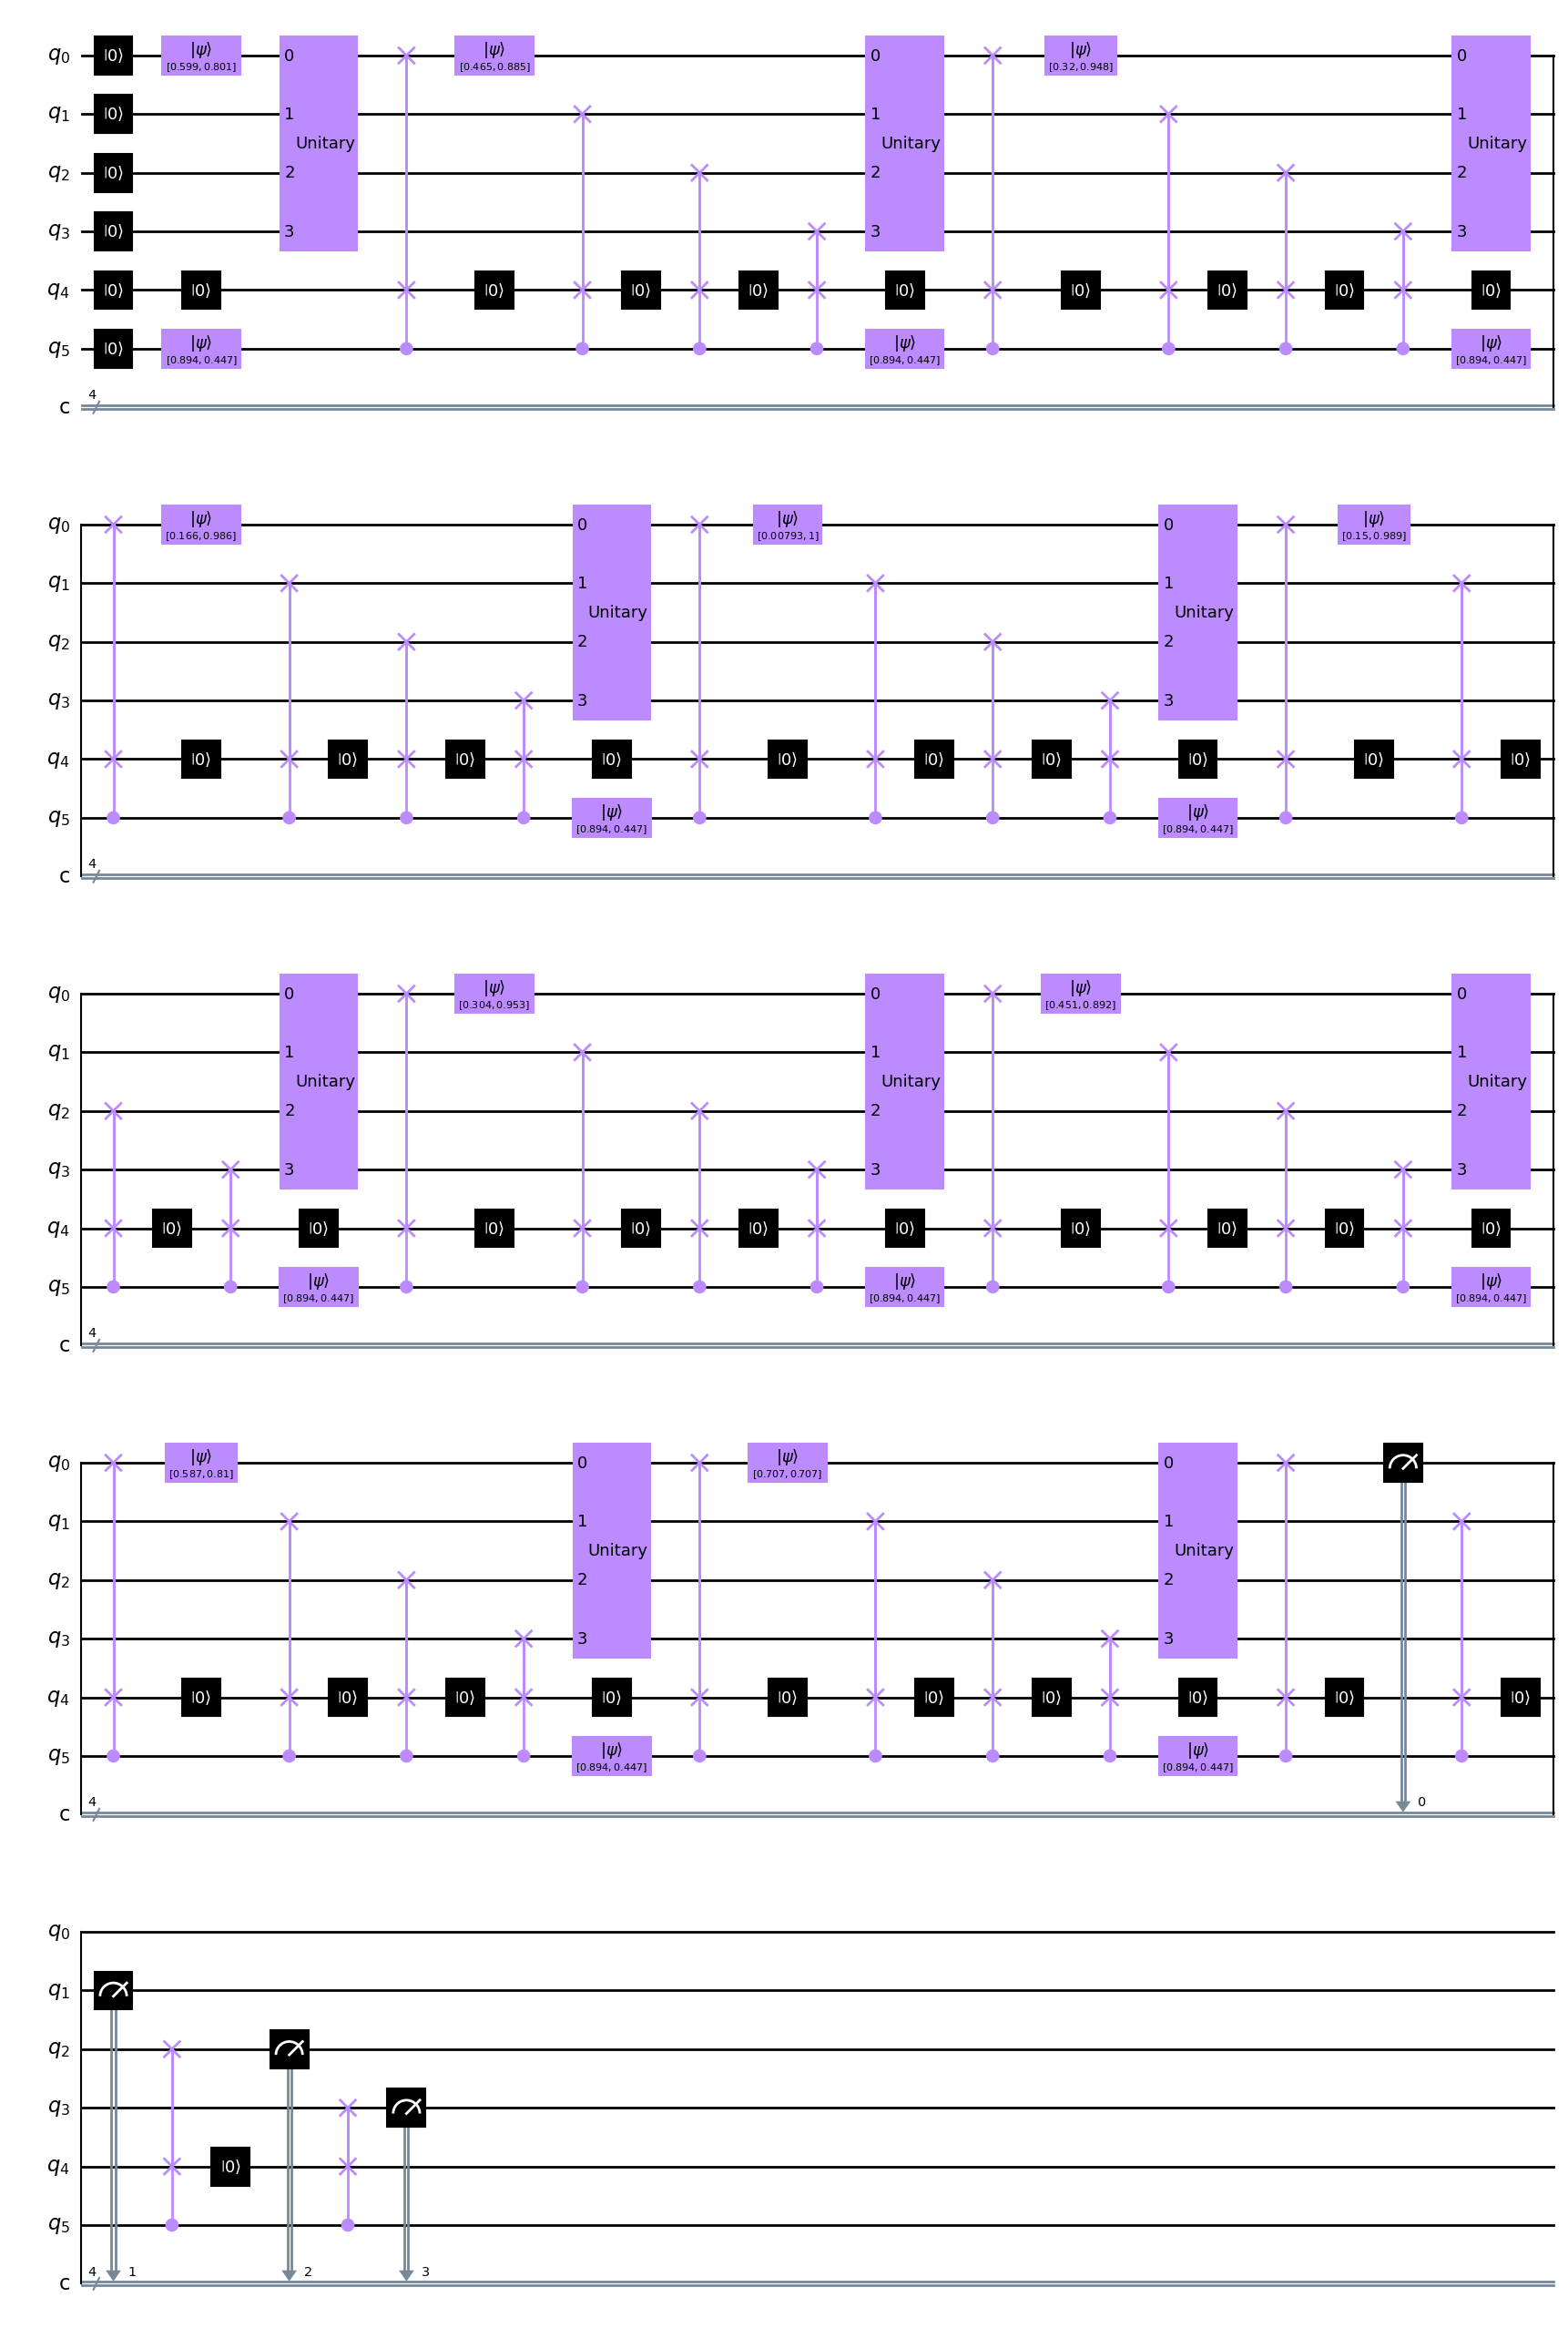

In [34]:
def build_method(circ, timestep, operator, reset_prob):
    circ.initialize(np.array([np.sqrt(timestep),
        np.sqrt(1-timestep)], dtype=complex
    ), 0)
    circ.initialize(np.array([np.sqrt(1-reset_prob), np.sqrt(reset_prob)], dtype=complex), 5)
    circ.unitary(operator, circ.qubits[:-2])
    for i in range(4):
        circ.reset(4)
        circ.cswap(5, 4, i)
    return circ

res = QReservoir(qubits=6, layers=[
    Layers.Reset(),
    Layers.Timeseries(build_method=build_method, incrementally=True, M=5),
    Layers.Measurement(range(4))
], operator=random_unitary(2**4), analyze_function=lambda res: res[-4:], reset_prob=0.2)


timeseries = (1 + np.sin(np.linspace(0, 10*np.pi, 100)))/2
states = res.run(timeseries, shots=10000, transpile=True)

res.circuit.draw('mpl')



(<Figure size 2000x2000 with 4 Axes>,
 array([<Axes: title={'center': 'Feature 1'}>,
        <Axes: title={'center': 'Feature 2'}>,
        <Axes: title={'center': 'Feature 3'}>,
        <Axes: title={'center': 'Feature 4'}>], dtype=object))

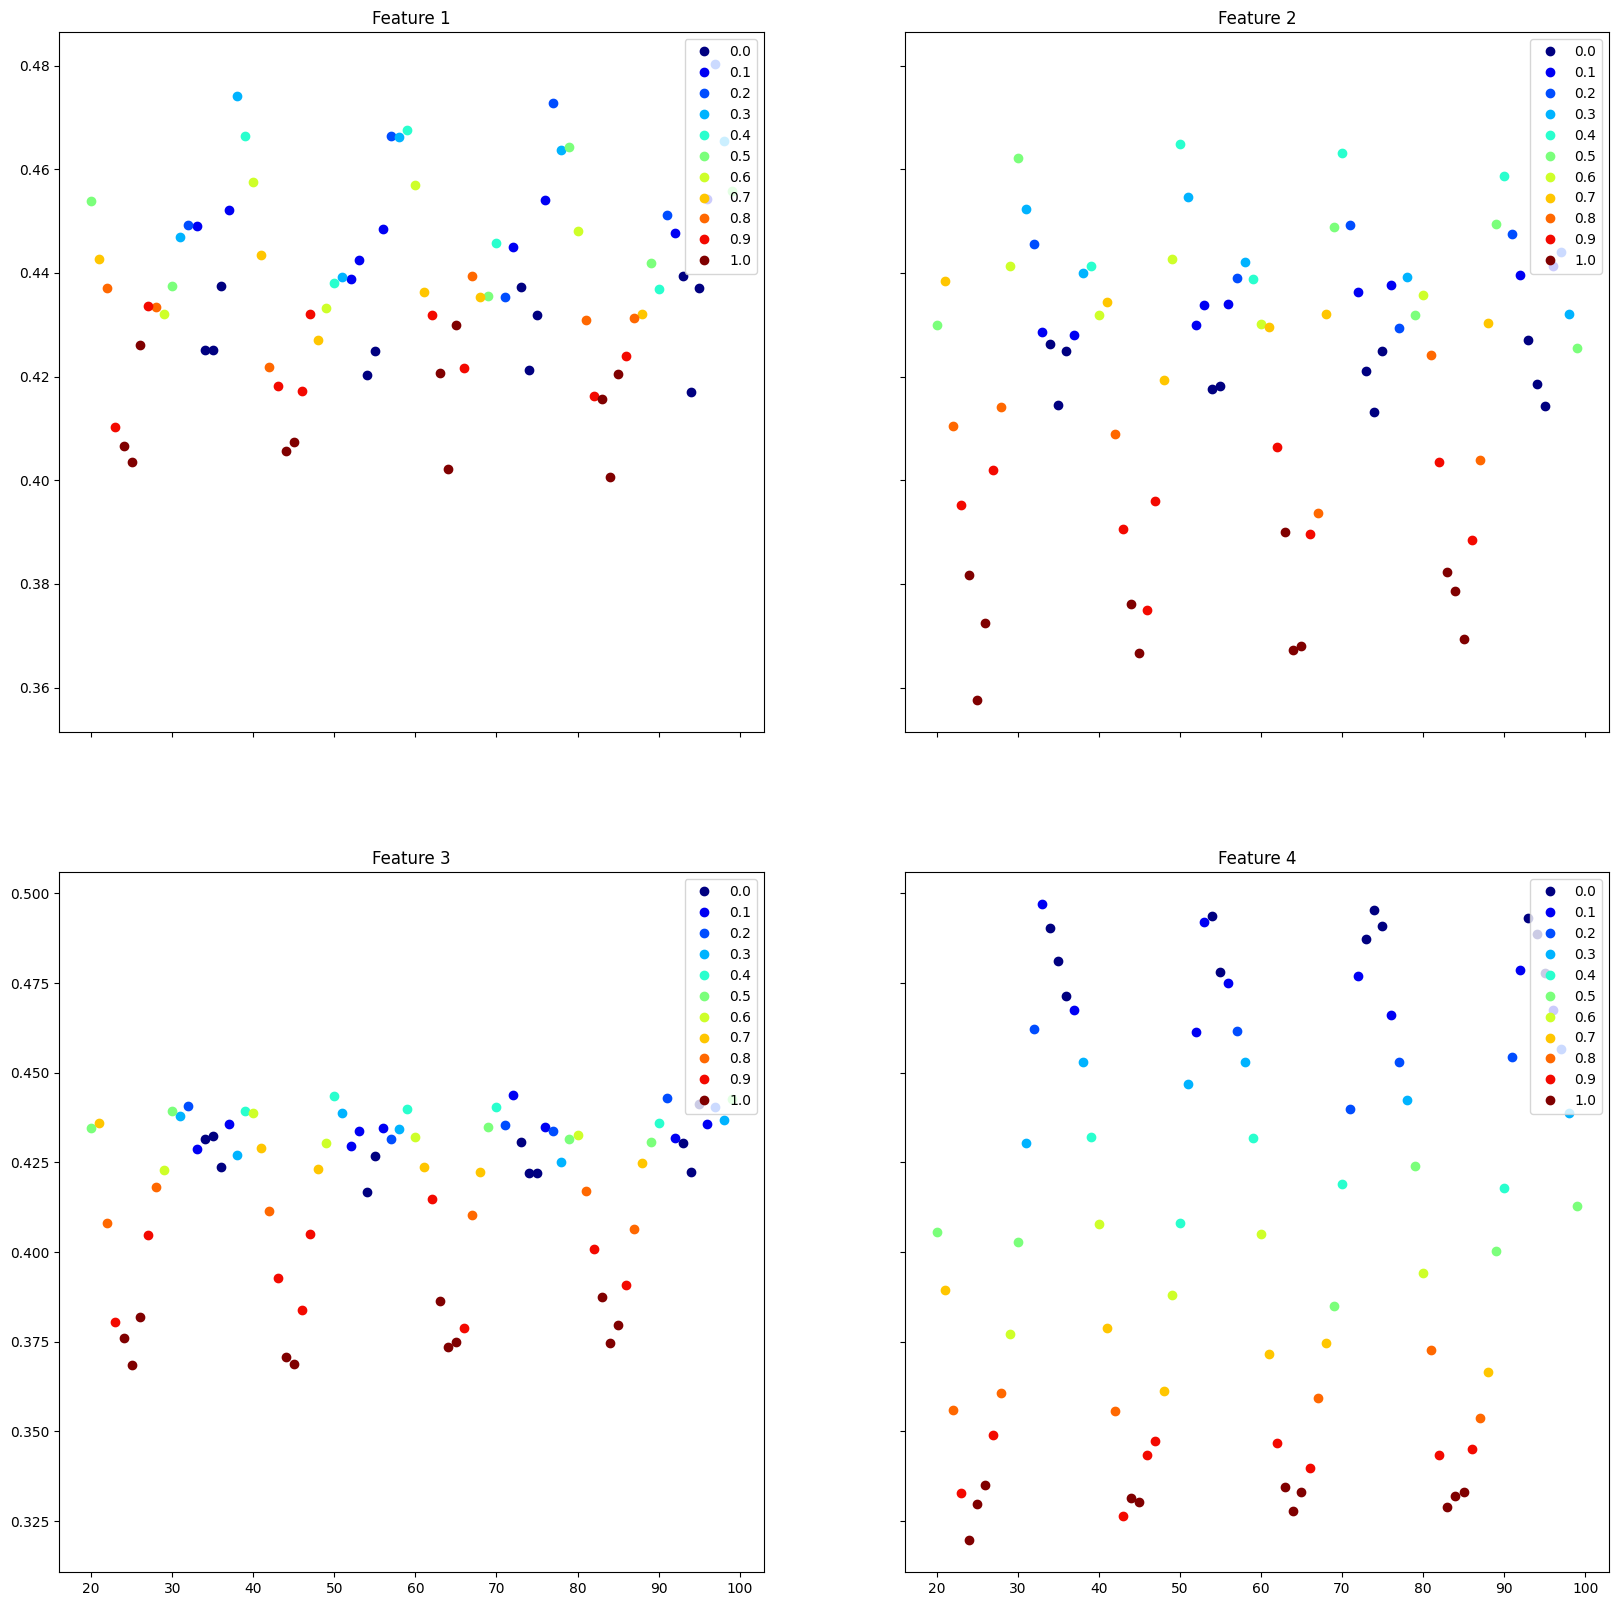

In [35]:
WARMUP = 0.2
utilities.result_plotter(states, np.round(timeseries, 1), WARMUP)

In [39]:
print(states.shape)
n = 3
d = states.shape[1]
new_states = np.zeros((states.shape[0], n * d))
for i in range(n, len(states)):
    for j in range(n):
        new_states[i][j: (j+1)*d] = states[i-j].copy
print(new_states.shape)
print(new_states)

(100, 4)


TypeError: float() argument must be a string or a number, not 'builtin_function_or_method'

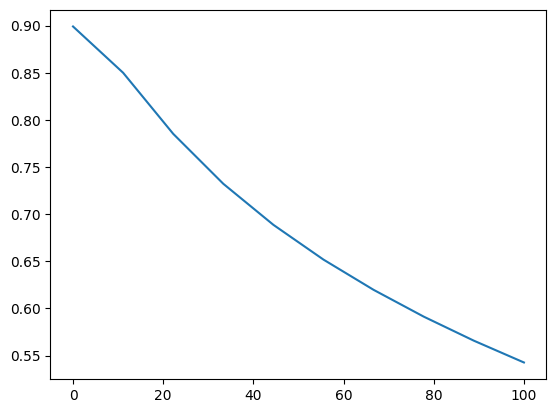

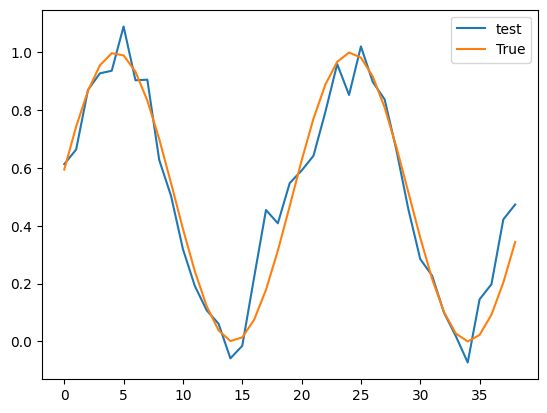

In [36]:
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



warmup = int(len(states) * WARMUP)
x = states[:-1]
target = timeseries[1:]


x = x[warmup:]
target = target[warmup:]

# train_x, test_x, train_y, test_y = train_test_split(x, target, test_size=0.33)
M = len(x)
train_x = x[:M//2]
train_y = target[:M//2]

test_x = x[M//2:]
test_y = target[M//2:]
plt.figure()
alpha_space = np.linspace(0, 100, 10)

scores = np.zeros(len(alpha_space))
for i, alpha in enumerate(alpha_space):
    model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    model.fit(train_x, train_y)
    scores[i] = model.score(test_x, test_y)

model = make_pipeline(StandardScaler(), Ridge(alpha=0))
model.fit(train_x, train_y)

plt.plot(alpha_space, scores)
plt.figure()
plt.plot(model.predict(test_x[1:]), label="test")
plt.plot(test_y[:-1], label="True")
plt.legend()
plt.show()